In [1]:
import sys
import os
import gc
import re
import json
import copy
import random

# Scientific Libraries
import numpy as np
from scipy.stats import beta

# Optimization
from gurobipy import Model, GRB, quicksum
from networkx.algorithms.flow import shortest_augmenting_path

# Graph & Plotting\
import matplotlib
matplotlib.use("Agg")

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

# MBNpy Modules
import matplotlib
matplotlib.use("Agg")
from mbnpy import brc, cpm, variable, operation, branch, config

# Local Module
import batch

# Clean up memory
gc.collect()
%matplotlib inline


C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_6704\3474072973.py:28: DeprecationWarning: operation.py is deprecated and replaced with inference.py. Please update your imports.
  from mbnpy import brc, cpm, variable, operation, branch, config


In [2]:
import json

json_path = r"D:\MINJI\NETWORK RELIABILITY\Data\toy_data.json"

with open(json_path, 'r') as f:
    data = json.load(f)

def to_tuple_dict(d):
    return {k: tuple(v) for k, v in d.items()}

nodes = to_tuple_dict(data["nodes"])
edges = to_tuple_dict(data["edges"])
arcs = list(edges.values())
arc_distance = data["arc_distance"]
intact_capacity = data["intact_capacity"]
intact_capacity = {k: float(v) for k, v in intact_capacity.items()}
probs = data.get("probs", {})  # JSON 등에서 불러온 probs가 문자열 key를 가질 경우 처리
probs = {
    k: {int(inner_k): v for inner_k, v in inner_d.items()}
    for k, inner_d in probs.items()
}


print("nodes = {")
for k, v in nodes.items():
    print(f"    '{k}': {v},")
print("}\n")

print("edges = {")
for k, v in edges.items():
    print(f"    '{k}': {v},")
print("}\n")

print("arc_distance = {")
for k, v in arc_distance.items():
    print(f"    '{k}': {round(v, 2)},")
print("}\n")

print("intact_capacity = {")
for k, v in intact_capacity.items():
    print(f"    '{k}': {round(v, 1)},")
print("}\n")

print("probs = {")
for k, d in probs.items():
    print(f"    '{k}': {{0: {d[0]}, 1: {d[1]}}},")  # 🔁 여기가 핵심 수정
print("}")


nodes = {
    'n1': (14220973.722359, 4130645.024699),
    'n2': (14146717.100649, 4132230.850867),
    'n3': (14069555.081924, 4135563.205243),
    'n4': (14176063.932488, 4142425.232937),
    'n5': (14193634.040681, 4156553.213346),
    'n6': (14133595.120358, 4161955.794115),
    'n7': (14106102.458275, 4165750.415781),
    'n8': (14364964.734294, 4179610.177365),
    'n9': (14114209.919848, 4182618.141239),
    'n10': (14262065.814782, 4184305.294959),
    'n11': (14187881.60784, 4186131.108938),
    'n12': (14359921.684878, 4191814.358808),
    'n13': (14313076.547757, 4196036.78356),
    'n14': (14171404.111818, 4202524.330698),
    'n15': (14113052.598481, 4204750.16163),
    'n16': (14358584.399463, 4205643.497223),
    'n17': (14341165.230242, 4216763.431199),
    'n18': (14177745.987252, 4219927.831905),
    'n19': (14334781.476341, 4228592.823673),
    'n20': (14119979.491602, 4242381.548748),
    'n21': (14126889.141603, 4272193.648242),
    'n22': (14329842.484908, 4275892

In [3]:
# 3. Compute maximum allowable distance
json_path = r"D:\MINJI\NETWORK RELIABILITY\Data\demand_data_ko.json"
with open(json_path, "r", encoding="utf-8") as f:
    demand = json.load(f)

demand_dict = {}
max_distance = {}
avg_velo = 149  # Speed in km/h
commodity_name_map = {}  
delay_time = 180

for idx, item in enumerate(demand, start=1):
    key = f"k{idx}"
    demand_dict[key] = {
        "origin": item["origin_name"],
        "destination": item["destination_name"],
        "amount": item["journeys"],
        "distance": item["distance"]
    }
    max_allowable_ad_distance = avg_velo * delay_time / 60
    max_distance[key] = item["distance"] + max_allowable_ad_distance # 여유 거리 설정

print("Maximum Allowable Distance Per OD Pair:\n")

for k in max_distance:
    base_dist = demand_dict[k]['distance']
    extra_dist = round(max_distance[k] - base_dist, 2)
    print(f"{k}:")
    print(f"  - Origin → Destination: {demand_dict[k]['origin']} → {demand_dict[k]['destination']}")
    print(f"  - Base Distance: {base_dist:.2f} m")
    print(f"  - Extra Allowance: {extra_dist:.2f} m")
    print(f"  - Max Allowable Distance: {max_distance[k]:.2f} m\n")



def generate_comps_st(probs): # 자동으로 2개씩 묶어 state 랜덤 설정하여 컴포넌트 상태 생성
    comps_st = {}

    # edge ID를 정렬해서 2개씩 묶기
    edge_ids = sorted(probs.keys(), key=lambda x: int(x[1:]))  # e1, e2, ..., e10 기준
    edge_pairs = [ (edge_ids[i], edge_ids[i+1]) for i in range(0, len(edge_ids), 2) ]

    for e_fwd, e_bwd in edge_pairs:
        prob_dict = probs[e_fwd]  # e_fwd 기준으로 상태 결정
        states = list(prob_dict.keys())
        probabilities = list(prob_dict.values())
        state = random.choices(states, weights=probabilities, k=1)[0]

        comps_st[e_fwd] = state
        comps_st[e_bwd] = state

    return comps_st


Maximum Allowable Distance Per OD Pair:

k1:
  - Origin → Destination: n3 → n20
  - Base Distance: 126543.16 m
  - Extra Allowance: 447.00 m
  - Max Allowable Distance: 126990.16 m

k2:
  - Origin → Destination: n3 → n21
  - Base Distance: 157145.52 m
  - Extra Allowance: 447.00 m
  - Max Allowable Distance: 157592.52 m

k3:
  - Origin → Destination: n3 → n29
  - Base Distance: 177995.84 m
  - Extra Allowance: 447.00 m
  - Max Allowable Distance: 178442.84 m

k4:
  - Origin → Destination: n3 → n36
  - Base Distance: 218082.46 m
  - Extra Allowance: 447.00 m
  - Max Allowable Distance: 218529.46 m

k5:
  - Origin → Destination: n3 → n37
  - Base Distance: 239467.32 m
  - Extra Allowance: 447.00 m
  - Max Allowable Distance: 239914.32 m

k6:
  - Origin → Destination: n3 → n38
  - Base Distance: 256187.89 m
  - Extra Allowance: 447.00 m
  - Max Allowable Distance: 256634.89 m

k7:
  - Origin → Destination: n7 → n20
  - Base Distance: 79140.86 m
  - Extra Allowance: 447.00 m
  - Max Allowa

In [4]:
# ----------------------------
# 4. MCNF system function
# ----------------------------
def MCNF_systemfunc_test(arcs, comps_st, edges, arc_capacity, demand, max_distance, arc_distance, threshold_ratio):

    edge_map = {v: k for k, v in edges.items()}  # (i, j) → edge_id
    
    model = Model("MCNF")
    model.setParam('OutputFlag', 0)

    flow = {}
    unmet_demand = {}

    for k, info in demand.items():
        origin = info['origin']
        unmet_demand[k] = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unmet_{k}")
        for i, j in arcs:
            edge_id = edge_map.get((i, j))
            cap = arc_capacity.get(edge_id, 0)
            flow[k, i, j] = model.addVar(lb=0, ub=cap, vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")



    # Objective
    total_demand = sum(info['amount'] for info in demand.values())
    model.setObjective(quicksum(unmet_demand[k] for k in demand), GRB.MINIMIZE)



    # Flow conservation
    nodes_set = set(n for arc in arcs for n in arc)
    for k, info in demand.items():
        o, d, amt = info['origin'], info['destination'], info['amount']
        for n in nodes_set:
            inflow = quicksum(flow[k, i, j] for i, j in arcs if j == n)
            outflow = quicksum(flow[k, i, j] for i, j in arcs if i == n)
            if n == o:
                model.addConstr(outflow - inflow == amt - unmet_demand[k])
            elif n == d:
                model.addConstr(outflow - inflow == -amt + unmet_demand[k])
            else:
                model.addConstr(outflow - inflow == 0)

    # Arc capacity
    for i, j in arcs:
        edge_id = edge_map.get((i, j))
        model.addConstr(quicksum(flow[k, i, j] for k in demand) <= arc_capacity.get(edge_id, 0))    

    # Distance limit
        for k, info in demand.items():
            distance_expr = quicksum(arc_distance[edge_map[(i, j)]] * flow[k, i, j] for i, j in arcs if (i, j) in edge_map)
            total_flow = quicksum(flow[k, i, j] for i, j in arcs if i == info['origin'])
            model.addConstr(distance_expr <= max_distance[k] * total_flow)



    model.optimize()

    if model.status == GRB.OPTIMAL:

        expected_loss = model.objVal
        threshold = total_demand * threshold_ratio
        edge_flows = {e: 0.0 for e in edges}
        od_used_edges = {k: set() for k in demand}
        od_flows = {k: [] for k in demand}

        for (k, i, j), var in flow.items():
            if var.x > 0:
                od_flows[k].append(((i, j), var.x))

        for (k, i, j), var in flow.items():
            if var.x > 0:
                edge_id = edge_map.get((i, j))  
                if edge_id:
                    edge_flows[edge_id] += var.X
                    od_used_edges[k].add(edge_id)

        if expected_loss < threshold:
            sys_st = 's'
            min_comps_st = {}
            for (k, i, j), var in flow.items():
                if var.x > 0:
                    edge_id = edge_map.get((i, j))
                    if edge_id:
                        min_comps_st[edge_id] = 1

        else:
            sys_st = 'f'
            min_comps_st = None

        return expected_loss, sys_st, min_comps_st
    else:
        return None, None, None, None, None

In [5]:
def shortestpath_systemfunc(arcs, comps_st, edges, arc_capacity, demand, max_distance, arc_distance, threshold_ratio):
    import networkx as nx
    from networkx.algorithms.flow import shortest_augmenting_path
    from types import SimpleNamespace

    # 각 컴포넌트의 상태(0/1)에 따른 capacity 값 정의
    varis = {e: SimpleNamespace(values={0: 0, 1: 1}) for e in edges}

    total_demand = sum(info["amount"] for info in demand.values())
    expected_loss = 0.0
    used_links_set = set()
    edge_flows = {e: 0.0 for e in edges}

    for k, info in demand.items():
        origin = info["origin"]
        destination = info["destination"]
        amount = info["amount"]

        # 네트워크 구성
        G = nx.Graph()
        for e, state in comps_st.items():
            u, v = edges[e]
            G.add_edge(u, v, capacity=varis[e].values[int(state)])

        # 도착지에 new_d 노드 연결
        G.add_edge(destination, 'new_d', capacity=1)

        try:
            f_val, f_dict = nx.maximum_flow(G, origin, 'new_d', capacity='capacity',
                                            flow_func=shortest_augmenting_path)
        except:
            f_val = 0
            f_dict = {}

        if f_val == 0:
            expected_loss += amount
        else:
            for e in edges:
                u, v = edges[e]
                flow_uv = f_dict.get(u, {}).get(v, 0)
                flow_vu = f_dict.get(v, {}).get(u, 0)
                if max(flow_uv, flow_vu) > 0:
                    used_links_set.add(e)
                    edge_flows[e] += amount

    threshold = total_demand * threshold_ratio
    expected_loss = min(max(expected_loss, 0.0), total_demand)

    if expected_loss < threshold:
        sys_st = 's'
        min_comps_st = {e: 1 for e in used_links_set}
    else:
        sys_st = 'f'
        min_comps_st = None

    return expected_loss, sys_st, min_comps_st


In [6]:
comps_st = generate_comps_st(probs)
comps_st = {e: int(v) for e, v in comps_st.items()}
#comps_st = {e: 1 for e in intact_capacity}  # 모든 엣지를 1로 설정
arc_capacity = {e: float(intact_capacity[e]) * comps_st[e] for e in intact_capacity}
print(arc_capacity)

# 수정된 버전 (arc_capacity를 매 호출마다 생성하도록)
sys_fun_mcnf = lambda comps_st: MCNF_systemfunc_test(
    arcs=arcs,
    comps_st=comps_st,
    edges=edges,
    arc_capacity={e: float(intact_capacity[e]) * int(comps_st[e]) for e in intact_capacity},
    demand=demand_dict,
    max_distance=max_distance,
    arc_distance=arc_distance,
    threshold_ratio=0.1
)


sys_fun_shortest = lambda comps_st: shortestpath_systemfunc(
    arcs=arcs,
    comps_st=comps_st,
    edges=edges,
    arc_capacity={e: float(intact_capacity[e]) * int(comps_st[e]) for e in intact_capacity},
    demand=demand_dict,
    max_distance=max_distance,
    arc_distance=arc_distance,
    threshold_ratio=0.1
)

print("\n🔹 Input Values:")
print("Component States (comps_st):", comps_st)
print("Edges:", edges)
print("Arc Capacity:", arc_capacity)
print("Demand:", demand_dict)
print("Max Distance:", max_distance)
print("Arc Distance:", arc_distance)

expected_loss_mcnf, sys_st_mcnf, min_comps_st_mcnf = sys_fun_mcnf(comps_st)
expected_loss_sp, sys_st_sp, min_comps_st_sp = sys_fun_shortest(comps_st)


print("\n🔹 Output Values:")
print("System State (MCNF):", sys_st_mcnf)
print("System State (Shortest):", sys_st_sp)
print("Minimum component state (MCNF):", min_comps_st_mcnf) 
print("Minimum component state (Shortest):", min_comps_st_sp) 
print("Expected Loss (MCNF):", expected_loss_mcnf) 
print("Expected Loss (Shortest):", expected_loss_sp)

{'e1': 1070294.0, 'e2': 1070294.0, 'e3': 567441.0, 'e4': 567441.0, 'e5': 933838.5, 'e6': 933838.5, 'e7': 118699.0, 'e8': 118699.0, 'e9': 0.0, 'e10': 0.0, 'e11': 889216.0, 'e12': 889216.0, 'e13': 4615366.5, 'e14': 4615366.5, 'e15': 305036.99999999994, 'e16': 305036.99999999994, 'e17': 269834.0, 'e18': 269834.0, 'e19': 0.0, 'e20': 0.0, 'e21': 1443290.0, 'e22': 1443290.0, 'e23': 208162.0, 'e24': 208162.0, 'e25': 529316.0, 'e26': 529316.0, 'e27': 206304.49999999997, 'e28': 206304.49999999997, 'e29': 1031568.5, 'e30': 1031568.5, 'e31': 17360.5, 'e32': 17360.5, 'e33': 13212.0, 'e34': 13212.0, 'e35': 389297.5, 'e36': 389297.5, 'e37': 1371198.0, 'e38': 1371198.0, 'e39': 5069035.5, 'e40': 5069035.5, 'e41': 3670.0, 'e42': 3670.0, 'e43': 743219.5, 'e44': 743219.5, 'e45': 5530552.0, 'e46': 5530552.0, 'e47': 1926450.5, 'e48': 1926450.5, 'e49': 4754412.0, 'e50': 4754412.0, 'e51': 0.0, 'e52': 0.0, 'e53': 365240.99999999994, 'e54': 365240.99999999994, 'e55': 113190.5, 'e56': 113190.5, 'e57': 1599962.0

In [ ]:
# BRC 실행
rules_init = {'s': [], 'f': []}

assert all(isinstance(r, dict) for r in rules_init['s']), "Survival rules must be dict"
assert all(isinstance(r, dict) for r in rules_init['f']), "Failure rules must be dict"

brs_shortest, rules_shortest, sys_res_shortest, monitor_shortest = brc.run(
    probs=probs, 
    sys_fun=sys_fun_shortest, 
    max_sf=np.inf, 
    max_nb=np.inf, 
    pf_bnd_wr=0.0, 
    max_rules=50,  
    active_decomp=10,
    display_freq=5,
    brs=[],
    rules=rules_init
)

# Check if BRC stopped due to max_rules
if len(rules_shortest['s'] + rules_shortest['f']) >= 50:
    print("\n🔹 BRC terminated because 100 rules have been found.")

# System failure probability
Pf_shortest = sum(branch.p for branch in brs_shortest if branch.down_state == 'f')
print(f"System Failure Probability (P_f): {Pf_shortest}")

# Identify unknown branches (brs_u)
brs_u_shortest = [branch for branch in brs_shortest if branch.down_state == 'u' or branch.up_state == 'u']

# Print rules
print("All Survival Rules:")
for i, rule in enumerate(rules_shortest['s'], 1):
    print(f"Rule {i}: {rule}")

print("\nAll Failure Rules:")
for i, rule in enumerate(rules_shortest['f'], 1):
    print(f"Rule {i}: {rule}")

[System function runs 5]..
The # of found non-dominated rules (f, s): 2 (0, 2)
Probability of branchs (f, s, u): (0.0000e+00, 1.55e-07, 1.0000e+00)
The # of branches (f, s, u), (min, avg) len of rf: 386 (0, 3, 383), (0, 0.00)
Elapsed seconds (average per round): 2.13e+01 (4.27e+00)
[System function runs 10]..
The # of found non-dominated rules (f, s): 2 (0, 2)
Probability of branchs (f, s, u): (0.0000e+00, 1.55e-07, 1.0000e+00)
The # of branches (f, s, u), (min, avg) len of rf: 386 (0, 3, 383), (0, 0.00)
Elapsed seconds (average per round): 2.72e+01 (2.72e+00)
[System function runs 15]..
The # of found non-dominated rules (f, s): 2 (0, 2)
Probability of branchs (f, s, u): (0.0000e+00, 1.55e-07, 1.0000e+00)
The # of branches (f, s, u), (min, avg) len of rf: 155 (0, 3, 152), (0, 0.00)
Elapsed seconds (average per round): 3.62e+01 (2.41e+00)
[System function runs 20]..
The # of found non-dominated rules (f, s): 2 (0, 2)
Probability of branchs (f, s, u): (0.0000e+00, 1.55e-07, 1.0000e+00)


In [ ]:
print("\n🔹 Running Monte Carlo Simulation (MCS) after BRC termination.")

def sys_fun_rs_shortest(sample1):
    val, sys_st, _ = sys_fun_shortest(sample1)
    return val, sys_st

# Define system variable
varis = {}
for k in edges:
    varis[k] = variable.Variable(name=k, values=[0, 1]) 
varis['sys_event'] = variable.Variable(name='sys_event', values=['f', 's', 'u'])

# Create CPMs for each component event
cpms = {}  # Initialize CPMs
for k, v in edges.items():
    cpms[k] = cpm.Cpm(
        variables=[varis[k]], 
        no_child=1, 
        C=np.array([[0], [1]]),  # Define states (0: fail, 1: survive)
        p=np.array([probs[k][0], probs[k][1]])  # Assign probabilities
    )

def get_composite_state(vari, states):
    added = set(states)
    if added not in vari.B:
        vari.B.append(added)
    cst = vari.B.index(added)
    return vari, cst

import mbnpy.variable as variable
variable.get_composite_state = get_composite_state

# Generate system constraint matrix
Csys, varis = brc.get_csys(brs_shortest, varis, {'f': 0, 's': 1, 'u': 2})
Csys = np.array(Csys, dtype=np.int32)  # Ensure integer type

# Ensure "sys_event" exists in CPMs
if "sys_event" not in cpms:
    cpms["sys_event"] = cpm.Cpm(
        variables=[varis["sys_event"]] + [varis[e] for e in edges],
        no_child=1,
        C=np.zeros((1, len(edges) + 1), dtype=int),  # Initialize constraints matrix
        p=np.array([1.0])  # Set initial probability
    )

# Adjust constraint matrix dimensions if needed
expected_columns = len(cpms["sys_event"].variables)
actual_columns = Csys.shape[1]

if actual_columns != expected_columns:
    print(f"Warning: Adjusting Csys! Expected {expected_columns} columns, but got {actual_columns}.")
    if actual_columns > expected_columns:
        Csys = Csys[:, :expected_columns]  # Trim excess columns
    else:
        missing_cols = expected_columns - actual_columns
        extra_cols = np.full((Csys.shape[0], missing_cols), 0)  # Fill missing columns with 0
        Csys = np.hstack((Csys, extra_cols))

cpms["sys_event"].Cs = Csys  # Assign constraint matrix to CPMs


# Transform unknown branches for MCS
brs_u_transformed_shortest = [
    (
        b.down,
        b.up,
        round(float(b.p), 20),  # Convert probability to float and round
        b.down_state,
        b.up_state,
    )
    for b in brs_u_shortest
]

# Run Monte Carlo Simulation for unknown branches
cpms_shortest, mcs_result_shortest = batch.mcs_unknown(
    brs_u=brs_u_transformed_shortest,
    probs=probs,
    sys_fun_rs=sys_fun_rs_shortest,
    cpms=cpms,
    sys_name="sys_event",
    cov_t=0.01,  # Convergence threshold
    sys_st_monitor=0,  # System failure monitoring state
    sys_st_prob=round(Pf_shortest, 20),  # Round system failure probability
    rand_seed=1  # Set random seed for reproducibility
)

# Print MCS results
print(f"\n🔹 MCS Completed. Failure Probability (pf): {mcs_result_shortest['pf']:.10e}")
print(f"   - COV: {mcs_result_shortest['cov']:.4e}")
print(f"   - Confidence Interval: [{mcs_result_shortest['cint_low']:.10e}, {mcs_result_shortest['cint_up']:.10e}]")
print(f"   - Number of Samples: {mcs_result_shortest['nsamp']}")

In [ ]:
# Run BRC with stopping criteria (max_rules = 100)
brs_mcnf, rules_mcnf, sys_res_mcnf, monitor_mcnf = brc.run(
    probs=probs, 
    sys_fun=sys_fun_mcnf, 
    max_sf=np.inf, 
    max_nb=np.inf, 
    pf_bnd_wr=0.0, 
    max_rules=50,  
    active_decomp=10,
    display_freq=5,
    brs=[],
)

# Check if BRC stopped due to max_rules
if len(rules_mcnf['s'] + rules_mcnf['f']) >= 50:
    print("\n🔹 BRC terminated because 100 rules have been found.")

# System failure probability
Pf_mcnf = sum(branch.p for branch in brs_mcnf if branch.down_state == 'f')
print(f"System Failure Probability (P_f): {Pf_mcnf}")

# Identify unknown branches (brs_u)
brs_u_mcnf = [branch for branch in brs_mcnf if branch.down_state == 'u' or branch.up_state == 'u']

# Print survival rules
print("All Survival Rules:")
for i, rule in enumerate(rules_mcnf['s'], 1):
    print(f"Rule {i}: {rule}")

# Print failure rules
print("\nAll Failure Rules:")
for i, rule in enumerate(rules_mcnf['f'], 1):
    print(f"Rule {i}: {rule}")

[System function runs 5]..
The # of found non-dominated rules (f, s): 4 (0, 4)
Probability of branchs (f, s, u): (0.0000e+00, 1.79e-07, 1.0000e+00)
The # of branches (f, s, u), (min, avg) len of rf: 1029 (0, 7, 1022), (0, 0.00)
Elapsed seconds (average per round): 2.37e+02 (4.75e+01)
[System function runs 10]..
The # of found non-dominated rules (f, s): 8 (0, 8)
Probability of branchs (f, s, u): (0.0000e+00, 2.47e-07, 1.0000e+00)
The # of branches (f, s, u), (min, avg) len of rf: 2025 (0, 14, 2011), (0, 0.00)
Elapsed seconds (average per round): 8.52e+02 (8.52e+01)
[System function runs 15]..
The # of found non-dominated rules (f, s): 13 (0, 13)
Probability of branchs (f, s, u): (0.0000e+00, 3.62e-07, 1.0000e+00)
The # of branches (f, s, u), (min, avg) len of rf: 840 (0, 16, 824), (0, 0.00)
Elapsed seconds (average per round): 1.20e+03 (7.98e+01)
[System function runs 20]..
The # of found non-dominated rules (f, s): 17 (0, 17)
Probability of branchs (f, s, u): (0.0000e+00, 4.35e-07, 1.

In [ ]:
print("\n🔹 Running Monte Carlo Simulation (MCS) after BRC termination.")

def sys_fun_rs(sample1):
    val, sys_st, _ = sys_fun_mcnf(sample1)
    return val, sys_st

# Define system variable
varis = {}
for k in edges:
    varis[k] = variable.Variable(name=k, values=[0, 1]) 
varis['sys_event'] = variable.Variable(name='sys_event', values=['f', 's', 'u'])

# Create CPMs for each component event
cpms = {}  # Initialize CPMs
for k, v in edges.items():
    cpms[k] = cpm.Cpm(
        variables=[varis[k]], 
        no_child=1, 
        C=np.array([[0], [1]]),  # Define states (0: fail, 1: survive)
        p=np.array([probs[k][0], probs[k][1]])  # Assign probabilities
    )

def get_composite_state(vari, states):
    added = set(states)
    if added not in vari.B:
        vari.B.append(added)
    cst = vari.B.index(added)
    return vari, cst

import mbnpy.variable as variable
variable.get_composite_state = get_composite_state

# Generate system constraint matrix
Csys, varis = brc.get_csys(brs_mcnf, varis, {'f': 0, 's': 1, 'u': 2})
Csys = np.array(Csys, dtype=np.int32)  # Ensure integer type

# Ensure "sys_event" exists in CPMs
if "sys_event" not in cpms:
    cpms["sys_event"] = cpm.Cpm(
        variables=[varis["sys_event"]] + [varis[e] for e in edges],
        no_child=1,
        C=np.zeros((1, len(edges) + 1), dtype=int),  # Initialize constraints matrix
        p=np.array([1.0])  # Set initial probability
    )

# Adjust constraint matrix dimensions if needed
expected_columns = len(cpms["sys_event"].variables)
actual_columns = Csys.shape[1]

if actual_columns != expected_columns:
    print(f"⚠ Warning: Adjusting Csys! Expected {expected_columns} columns, but got {actual_columns}.")
    if actual_columns > expected_columns:
        Csys = Csys[:, :expected_columns]  # Trim excess columns
    else:
        missing_cols = expected_columns - actual_columns
        extra_cols = np.full((Csys.shape[0], missing_cols), 0)  # Fill missing columns with 0
        Csys = np.hstack((Csys, extra_cols))

cpms["sys_event"].Cs = Csys  # Assign constraint matrix to CPMs


# Transform unknown branches for MCS
brs_u_transformed_mcnf = [
    (
        b.down,
        b.up,
        round(float(b.p), 20),  # Convert probability to float and round
        b.down_state,
        b.up_state,
    )
    for b in brs_u_mcnf
]

# Run Monte Carlo Simulation for unknown branches
cpms_mcnf, mcs_result_mcnf = batch.mcs_unknown(
    brs_u=brs_u_transformed_mcnf,
    probs=probs,
    sys_fun_rs=sys_fun_rs,
    cpms=cpms,
    sys_name="sys_event",
    cov_t=0.01,  # Convergence threshold
    sys_st_monitor=0,  # System failure monitoring state
    sys_st_prob=round(Pf_mcnf, 20),  # Round system failure probability
    rand_seed=1  # Set random seed for reproducibility
)

# Print MCS results
print(f"\n🔹 MCS Completed. Failure Probability (pf): {mcs_result_mcnf['pf']:.10e}")
print(f"   - COV: {mcs_result_mcnf['cov']:.4e}")
print(f"   - Confidence Interval: [{mcs_result_mcnf['cint_low']:.10e}, {mcs_result_mcnf['cint_up']:.10e}]")
print(f"   - Number of Samples: {mcs_result_mcnf['nsamp']}")


🔹 Running Monte Carlo Simulation (MCS) after BRC termination.
brs_u_probs: [0.07436680900696119, 0.06812681462561912, 0.06294419418287583, 0.05698459876168637, 0.0457833933709142, 0.04303540229140882, 0.037352273104287785, 0.03693439802869525, 0.03682142387593043, 0.033249659003536595, 0.03322938746858254, 0.02797389, 0.0267032317530259, 0.025789539522200013, 0.0253, 0.024968755183679095, 0.0226139514143719, 0.019973983547257032, 0.019227109081391608, 0.019188791447620743, 0.01787441804906984, 0.01702992017609384, 0.016712781945688912, 0.016051673584196718, 0.013886302817688578, 0.012217198072474868, 0.012187886533352439, 0.012005526394641851, 0.010998922947806666, 0.010800820636603977, 0.010792677654000002, 0.010763234471979001, 0.010639457275551243, 0.010425650442822556, 0.00845842327748689, 0.008217706994159845, 0.006721854865978349, 0.005245130388662734, 0.004274122286032181, 0.00355066888969325, 0.003429030822187943, 0.0032552794757811708, 0.0031501907928715442, 0.003044785859643

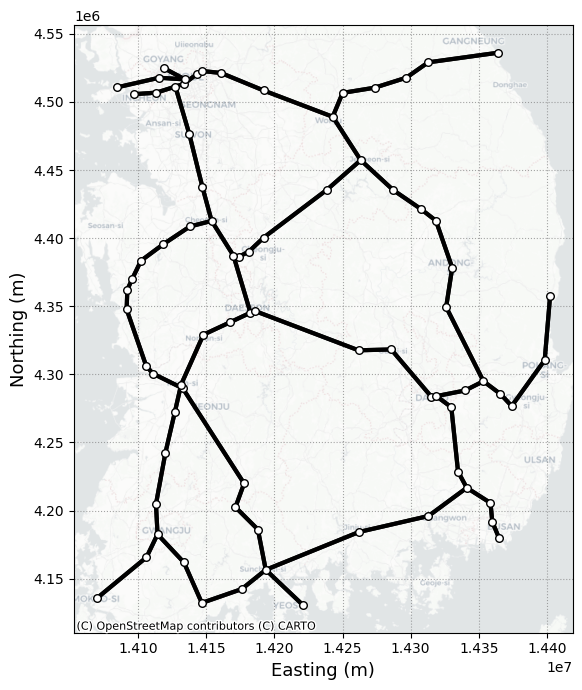

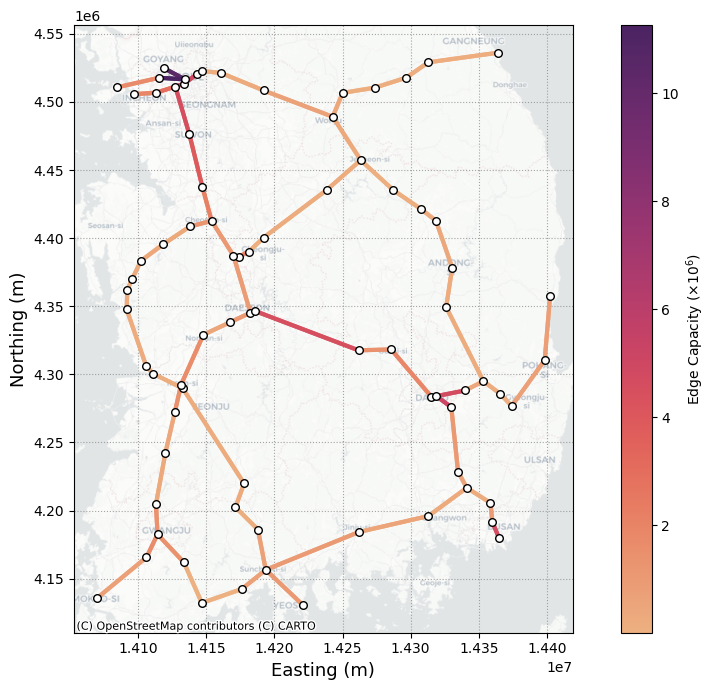

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns

# 1
# GeoDataFrame 생성
gdf_nodes = gpd.GeoDataFrame({'node': list(nodes.keys())},
                             geometry=[Point(x, y) for x, y in pos.values()],
                             crs="EPSG:3857")

gdf_edges = gpd.GeoDataFrame({'edge': list(edges.keys())},
                             geometry=[LineString([pos[u], pos[v]]) for (u, v) in edges.values()],
                             crs="EPSG:3857")

fig, ax = plt.subplots(figsize=(10, 7))
# 모든 엣지를 검은 실선으로!
gdf_edges.plot(ax=ax, color='black', linewidth=3, alpha=0.95, label="Edges")
# 노드 점
gdf_nodes.plot(ax=ax, color='white', markersize=30, edgecolor='black', label="Nodes", zorder=3)

ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.CartoDB.Positron, alpha=0.7)
ax.set_xlabel("Easting (m)", fontsize=13)
ax.set_ylabel("Northing (m)", fontsize=13)
ax.grid(True, linestyle=':', color='gray', linewidth=0.8, alpha=0.7)
plt.tight_layout()
plt.show()


# 2
# capacity 단위를 1e6으로 변환 (컬러바도 1e6 단위로 보임)
gdf_nodes = gpd.GeoDataFrame({'node': list(nodes.keys())},
    geometry=[Point(x, y) for x, y in pos.values()], crs="EPSG:3857")

edge_ids = list(edges.keys())
edge_lines = [LineString([pos[u], pos[v]]) for (u, v) in edges.values()]
edge_caps = [intact_capacity[edge_id] / 1e6 for edge_id in edge_ids]  # ← 1e6으로 변환
gdf_edges = gpd.GeoDataFrame({'edge': edge_ids, 'capacity': edge_caps},
    geometry=edge_lines, crs="EPSG:3857")

# seaborn "flare"은 밝은 노랑-주황-분홍 계열 (낮은값 어둡지 않음)
cmap_name = "flare"

fig, ax = plt.subplots(figsize=(10, 7))
gdf_edges.plot(ax=ax, column='capacity',
               cmap=sns.color_palette(cmap_name, as_cmap=True),
               linewidth=3, legend=True, alpha=0.95,
               legend_kwds={'label': r"Edge Capacity ($\times10^6$)"})

gdf_nodes.plot(ax=ax, color='white', markersize=30, edgecolor='black', label="Nodes", zorder=3)

ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.CartoDB.Positron, alpha=0.7)
ax.set_xlabel("Easting (m)", fontsize=13)
ax.set_ylabel("Northing (m)", fontsize=13)
ax.grid(True, linestyle=':', color='gray', linewidth=0.8, alpha=0.7)
plt.tight_layout()
plt.show()